# <center>Deep Learning and Optimization - Basic Task</center>



## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import math
import sys
import gym
import random
from gym import spaces, utils, logger
from gym.envs.toy_text import discrete

## Helper Function

In [2]:
# Running Mean (Moving average)
def running_mean(x, N):
    """Evaluate the moving average of window N of a vector"""
    cum_sum = np.cumsum(np.insert(x, 0, 0)) 
    return (cum_sum[N:] - cum_sum[:-N]) / float(N)

# 1. BASIC TASK 

## Environment Setup

#### Modified Cliff Walking 

In [3]:
#--------------------------------------------#
#          Environment Basics 
#--------------------------------------------#


# Specify the shape of grid environment 
WIDTH  = 10 # Number of columns in grid environment
HEIGHT = 10 # Number of rows in grid environment
START= (9, 0) # Starting Position
GOAL= (9, 9) # Goal Position

# Encode Actions
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [4]:
#--------------------------------------------#
#     Class Definition of Environment
#--------------------------------------------#


class ReviseCliffWalkEnv(discrete.DiscreteEnv):
    def __init__(self):
        """Initialize new Environement."""
        # Size of the environment space or grid
        self.width = WIDTH
        self.height = HEIGHT
        self.shape=(HEIGHT,WIDTH)        
        # Actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]       
        # Number of Actions and States
        numStates= np.prod(self.shape)
        numActions= np.count_nonzero(self.actions)
        # Starting State Position
        self.start_state_position = np.ravel_multi_index((9, 0), self.shape)
        # Create grid of environment 
        self._grid= np.zeros(self.shape, dtype=np.bool)
        # Cliff Position in the environment 
        self._grid[9, 1] = True
        self._grid[8, 2] = True
        self._grid[7, 2] = True
        self._grid[6, 3] = True
        self._grid[5, 3] = True
        self._grid[9, 8] = True
        self._grid[8, 7] = True
        self._grid[7, 7] = True
        self._grid[6, 6] = True
        self._grid[5, 6] = True
        self._grid[1:4, 1:3] = True
        self._grid[4, 2] = True
        self._grid[1:4, 7:9] = True
        self._grid[4, 7] = True
        self._grid[0:4, 4] = True
        self._grid[0:4, 5] = True
        self._grid[5:7, 0] = True
        self._grid[5:7, 9] = True
        self._grid[9, 4] = True
        self._grid[9, 5] = True       
        # Declare the starting position (9,0)
        isd = np.zeros(numStates)
        isd[self.start_state_position] = 1.0       
        # Calculate rewards on movement of all four actions
        P = {}
        for s in range(numStates):
            position = np.unravel_index(s, self.shape) # For each state           
            P[s] = {a: [] for a in range(numActions)} # For each action or direction 
            P[s][UP] = self._calculate_reward(position, [-1, 0])
            P[s][DOWN] = self._calculate_reward(position, [1, 0])
            P[s][RIGHT] = self._calculate_reward(position, [0, 1])
            P[s][LEFT] = self._calculate_reward(position, [0, -1])
        super(ReviseCliffWalkEnv, self).__init__(numStates, numActions, P, isd)

    def _limit_coordinates(self, coord):
        """Limits the agent to stay inside defined environment space."""
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord
    
    def _calculate_reward(self, current, change):
        """Calculate reward of the transition and mention terminating condition."""
        new_position = np.array(current) + np.array(change)
        new_position = self._limit_coordinates(new_position).astype(int)
        
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)

        if tuple(new_position) == (9,9):      # Reward at goal 
            reward = 100
        elif self._grid[tuple(new_position)]: # Reward at cliff
            reward = -100
        else:
            reward = -1                       # Reward at rest of the states      
       
        # Terminating condition
        finish = (self._grid[tuple(new_position)]) or (tuple(new_position) == (9,9))
        return [(1.0, new_state, reward, finish)]
    
    
    
    metadata = {'render.modes': ['human', 'ansi']}
    
    def render(self, mode='human'):
        """Visualize the environment."""
        outfile = sys.stdout
        print('-----------------------------------------')
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            output = "|"
            if self.s == s:
                output += " S "         # Starting State
            elif position == (9, 9):    # Goal State
                output += " G "       
            elif self._grid[position]:  # Cliff States
                output += " X "
            else:                       # Other states
                output += "   "          

            if position[1] == 0:
                output = output.lstrip()
            
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                if self._grid[position] != 0 or position == (9, 9) :
                    output += ' |\n'
                else :
                    output += '   |\n'
                output += '-----------------------------------------\n'
                
            outfile.write(output)
                  

## Environment Setup Examination

In [5]:
#--------------------------------------------#
#      Environment Setup Examination
#--------------------------------------------#

env=ReviseCliffWalkEnv()

print("Number of states:",env.nS)
print("Number of actions:",env.nA)

# Visualize the environment
env.render() 

Number of states: 100
Number of actions: 4
-----------------------------------------
|   |   |   |   | X | X |   |   |   |   |
-----------------------------------------
|   | X | X |   | X | X |   | X | X |   |
-----------------------------------------
|   | X | X |   | X | X |   | X | X |   |
-----------------------------------------
|   | X | X |   | X | X |   | X | X |   |
-----------------------------------------
|   |   | X |   |   |   |   | X |   |   |
-----------------------------------------
| X |   |   | X |   |   | X |   |   | X |
-----------------------------------------
| X |   |   | X |   |   | X |   |   | X |
-----------------------------------------
|   |   | X |   |   |   |   | X |   |   |
-----------------------------------------
|   |   | X |   |   |   |   | X |   |   |
-----------------------------------------
| S | X |   |   | X | X |   |   | X | G |
-----------------------------------------


## Random Agent

In [6]:
#--------------------------------------------#
#     Class Definition of Random Agent
#--------------------------------------------#


class RandomAgent:
    def __init__(self, state_size, action_size):
        """Initialize Random Agent."""   
        self.state_size = state_size
        self.action_size = action_size 

    def action_policy(self):
        """Choose an action according to a random policy."""
        action = np.random.choice(self.action_size)
        return action 
    
#--------------------------------------------#
#      1. Create Random Agent
#--------------------------------------------#

# Total number of states and actions in the environment 
state_size = env.nS
action_size = env.nA

# Create Random Agent
Random_Agent = RandomAgent(state_size, action_size)



#--------------------------------------------#
#      2. Training of Random Agent
#--------------------------------------------#

# To store the rewards per episode
Random_Rewards = [] 

# Number of episodes 
episodes=50000

# Start training
print("Training Started ....")
for episode in range(0, episodes):
    if episode%10000 == 0 : # Print episode
        print(" ---> Episode :", episode)        
    state = env.reset() # Reset Environment 
    done = False
    while not done:
        # Pick Next Action via random policy
        action = Random_Agent.action_policy()
        # Advance to next step
        next_state, reward, done, info = env.step(action) 
        
    Random_Rewards.append(reward) 
print('Training Finished')

Training Started ....
 ---> Episode : 0
 ---> Episode : 10000
 ---> Episode : 20000
 ---> Episode : 30000
 ---> Episode : 40000
Training Finished


Text(0.5, 1.0, 'Running Mean of Reward by Episode')

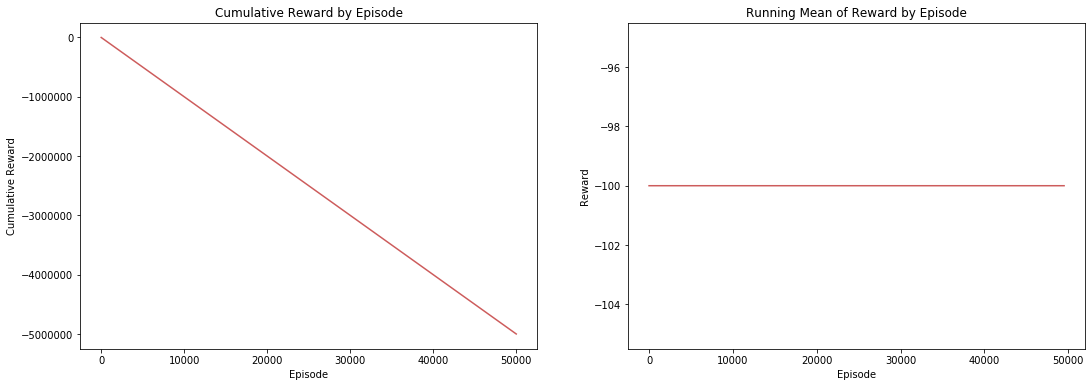

In [7]:
#--------------------------------------------#
#       3. Evaluation of Random Agent
#--------------------------------------------#

#Plot learning process 
plt.figure(figsize=(18,6))

# Calculate cumulative reward
Random_Rewards_cumu = np.cumsum(Random_Rewards)

# Visualize cumulative reward
plt.subplot(1,2,1)
plt.plot(Random_Rewards_cumu,color='indianred')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode');


# Calculate running mean of reward
Random_Rewards_run_mean = running_mean(Random_Rewards, 500) # N=500

# Visualize running mean of reward
plt.subplot(1,2,2)
plt.plot(Random_Rewards_run_mean,color='indianred')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')



## Q-Learning Agent

In [8]:
#--------------------------------------------#
#     Class Definition of Q-Learning Agent
#--------------------------------------------#


class QLearning:
    def __init__(self, state_size, action_size, discount_factor, learning_rate, 
                 epsilon):
        """Initialize Q-Learning Agent.""" 
        self.state_size = state_size
        self.action_size = action_size
        
        self.gamma = discount_factor   # discount rate
        self.alpha = learning_rate # learning rate

        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = 0.05 # minimum exploration rate
        self.epsilon_decay = 0.995 # exploration rate decay
        
        # Initial Q-matrix with 0 as initial reward 
        self.Qmatrix = np.zeros([state_size, action_size]) # 48= state_size, 4= action_size

    def action_policy_egreedy(self, state):  
        """Choose an action according to e-greedy policy."""
        # e-greedy policy
        if np.random.uniform(0, 1) > self.epsilon: # with probability 1-epsilon to take best action 
            action = np.argmax(self.Qmatrix[state]) # with highest Q-value
        else: # with probability epsilon to take random action
            action = np.random.choice(self.action_size)
        return action
            
            
    def update_Q(self, state, action, reward, next_state): 
        """Update Q-Value for next state."""
        old_value = self.Qmatrix[state, action]
        next_maxQ = np.max(self.Qmatrix[next_state])
        # Update Q entry of Current State
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_maxQ)
        self.Qmatrix[state, action] = new_value
        return None      

In [9]:
#--------------------------------------------#
#      1. Create Q-Learning Agent
#--------------------------------------------#


# Total number of states and actions in the environment 
state_size = env.nS
action_size = env.nA

# Create Q-Learning Agent
# discount_factor= 0.9 (gamma)
# learning_rate= 0.9 (alpha)
# epsilon= 1

Q_Agent = QLearning(state_size, action_size, 0.9, 0.9, 1)



#--------------------------------------------#
#      2. Training of Q-Learning Agent
#--------------------------------------------#

# To store the rewards per episode
Q_Rewards = [] 

# Number of episodes 
episodes = 50000  

# Start training
print("Training Started ....")
for episode in range(0, episodes):
    if episode%10000 == 0 : # Print episode
        print(" ---> Episode :", episode)        
    state = env.reset() # Reset Environment 
    done = False    
    while not done:    
        # Pick Next Action via egreedy policy
        action = Q_Agent.action_policy_egreedy(state)
        # Advance to next step
        next_state, reward, done, info = env.step(action) 
        # Update Q entries
        Q_Agent.update_Q(state, action, reward, next_state)
        state = next_state
        
    # Update Epsilon
    if Q_Agent.epsilon >= Q_Agent.epsilon_min : 
        Q_Agent.epsilon *= Q_Agent.epsilon_decay
    
    Q_Rewards.append(reward) 
print('Training Finished')

Training Started ....
 ---> Episode : 0
 ---> Episode : 10000
 ---> Episode : 20000
 ---> Episode : 30000
 ---> Episode : 40000
Training Finished


In [10]:
#--------------------------------------------#
#      3. Evaluation of Q-Learning Agent
#--------------------------------------------#


# Trained Q-Learning Agent Performance Evaluation

actions= [] # To store actions
states= [] # To store states
rewards= [] # To store rewards of each state

state = env.reset()
done = False
    
while not done:
        
    # Pick Next Action via best Q-Matrix
    action = np.argmax(Q_Agent.Qmatrix[state])
        
    # Advance to next step
    state, reward, done, info = env.step(action)
      
    actions.append(action) # Store actions
    states.append(state)   # Store optimize path
    rewards.append(reward) # Store rewards  

#Q-Matrix
print(Q_Agent.Qmatrix)


[[  -4.24317604   -3.60352893   -4.81885843   -4.24317604]
 [  -3.60352893   -2.89280992 -100.           -4.24317604]
 [  -2.89280992   -2.10312214 -100.           -3.60352893]
 [  -2.10312214 -100.           -1.22569126   -2.89280992]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [  15.1644717    17.96052411   12.64802453 -100.        ]
 [  17.96052411   21.06724901 -100.           15.1644717 ]
 [  21.06724901   24.51916557 -100.           17.96052411]
 [  24.51916557   24.51916557   28.35462841   21.06724901]
 [  -4.24317604 -100.           -5.33697259   -4.81885843]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [  -2.10312214 -100.           -0.25076807 -100.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [  15.1644717  -100.           10.38322208 -100.       

The optimal route is
    Action  State  Reward
0      UP     80      -1
1      UP     70      -1
2   RIGHT     71      -1
3      UP     61      -1
4      UP     51      -1
5      UP     41      -1
6    LEFT     40      -1
7      UP     30      -1
8      UP     20      -1
9      UP     10      -1
10     UP      0      -1
11  RIGHT      1      -1
12  RIGHT      2      -1
13  RIGHT      3      -1
14   DOWN     13      -1
15   DOWN     23      -1
16   DOWN     33      -1
17   DOWN     43      -1
18  RIGHT     44      -1
19  RIGHT     45      -1
20  RIGHT     46      -1
21     UP     36      -1
22     UP     26      -1
23     UP     16      -1
24     UP      6      -1
25  RIGHT      7      -1
26  RIGHT      8      -1
27  RIGHT      9      -1
28   DOWN     19      -1
29   DOWN     29      -1
30   DOWN     39      -1
31   DOWN     49      -1
32   LEFT     48      -1
33   DOWN     58      -1
34   DOWN     68      -1
35   DOWN     78      -1
36  RIGHT     79      -1
37   DOWN     89      -1
38 

Text(0.5, 1.0, 'Running Mean of Reward by Episode')

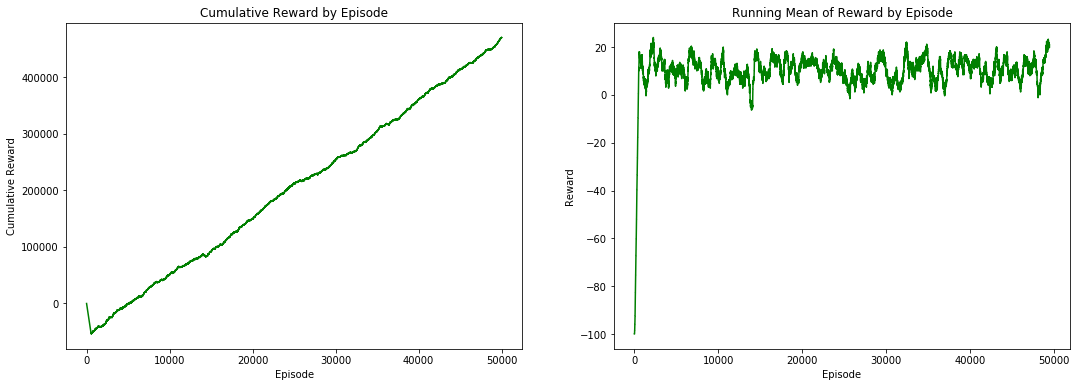

In [11]:
#--------------------------------------------#
#   Optimal Route using Q-Learning Agent
#--------------------------------------------#


#Decode Actions
ACTION_TO_STR = {0 : 'UP', 1 : 'RIGHT', 2 : 'DOWN', 3: 'LEFT'} 
actions= [ACTION_TO_STR[i] for i in actions]
    
    
#Table to show optimize Route
optimize=pd.DataFrame((list(zip(actions,states,rewards))), columns= ['Action', 'State', 'Reward'])
print('The optimal route is\n', optimize)


#--------------------------------------------#
#        Plot learning process 
#--------------------------------------------#
plt.figure(figsize=(18,6))


# Calculate cumulative reward
Q_Rewards_cumu = np.cumsum(Q_Rewards)

# Visualize cumulative reward
plt.subplot(1,2,1)
plt.plot(Q_Rewards_cumu, color='green')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode');


#Calculate Running Mean 
Q_Rewards_run_mean = running_mean(Q_Rewards, 500) # N=500

# Visualize running mean reward
plt.subplot(1,2,2)
plt.plot(Q_Rewards_run_mean, color='green')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')

## Comparison between the Q-Learning Agent and Random Agent

Text(0.5, 1.0, 'Running Mean of Reward by Episode')

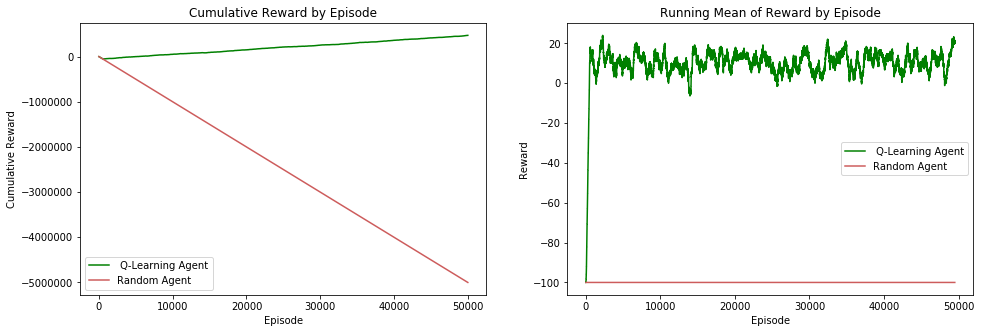

In [12]:
#--------------------------------------------#
#        Compare learning performance  
#--------------------------------------------#

#Plot
plt.figure(figsize=(16,5))

# Cumulative rewards
plt.subplot(1,2,1)
plt.plot(Q_Rewards_cumu, label=' Q-Learning Agent', color='green')
plt.plot(Random_Rewards_cumu, label='Random Agent', color='indianred')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')

# Running mean rewards
plt.subplot(1,2,2)
plt.plot(Q_Rewards_run_mean, label=' Q-Learning Agent', color='green')
plt.plot(Random_Rewards_run_mean, label='Random Agent', color='indianred')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')

## Grid Search for Hyperparameter Optimisation 

### 1. Discount Factor

In [13]:
#--------------------------------------------#
#                Discount Factor
#--------------------------------------------#

gammas=[0.5, 0.7, 0.8, 0.9, 1] #Discount Factor
state_size = env.nS
action_size = env.nA
result = []

print('Start ...')
for gamma in gammas:
    print(' gamma :', gamma)
    # Create Q-Learning Agent
    Q_Agent = QLearning(state_size, action_size, gamma, 0.8, 1)       
    # Training Agent
    episodes = 50000  #Number of episodes 
    Q_Rewards = [] # To store the rewards per episode
    for episode in range(0, episodes):
        state = env.reset() # Reset Environment 
        done = False
        while not done:
            # Pick Next Action via egreedy policy
            action = Q_Agent.action_policy_egreedy(state)
            # Advance to next step
            next_state, reward, done, info = env.step(action) 
            # Update Q entries
            Q_Agent.update_Q(state, action, reward, next_state)
            state = next_state
        
        # Update Epsilon 
        if Q_Agent.epsilon >= Q_Agent.epsilon_min : 
            Q_Agent.epsilon *= Q_Agent.epsilon_decay
    
        Q_Rewards.append(reward) 
    result.append([gamma, Q_Rewards])
print('End ...')

Start ...
 gamma : 0.5
 gamma : 0.7
 gamma : 0.8
 gamma : 0.9
 gamma : 1
End ...


In [14]:
#--------------------------------------------#
#         Performance Evaluation 
#--------------------------------------------#

data_gamma = pd.DataFrame(result, columns = ['gamma', 'reward'])  

#Get rewards of last 1000 episodes to shows the reward value achieved consistently towards the end of the process

#To store last 1000 episodes rewards
last_1k_rwrd_gamma=pd.DataFrame()

for i in range(0,5):
    last_1k_rwrd_gamma[i]=data_gamma['reward'][i][-1000:]
   
    
#Find mean of the last 1000 episodes rewards and store 
data_gamma['mean_rwrd_lst_1k']=last_1k_rwrd_gamma.mean()       
data_gamma

,gamma,reward,mean_rwrd_lst_1k
0,0.5,"[-100, -100, -100, -100, -100, -100, -100, -10...",14.4
1,0.7,"[-100, -100, -100, -100, -100, -100, -100, -10...",5.0
2,0.8,"[-100, -100, -100, -100, -100, -100, -100, -10...",16.6
3,0.9,"[-100, -100, -100, -100, -100, -100, -100, -10...",17.2
4,1.0,"[-100, -100, -100, -100, -100, -100, -100, -10...",9.2


Text(0.5, 1.0, 'Running Mean of Reward by Episode')

/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


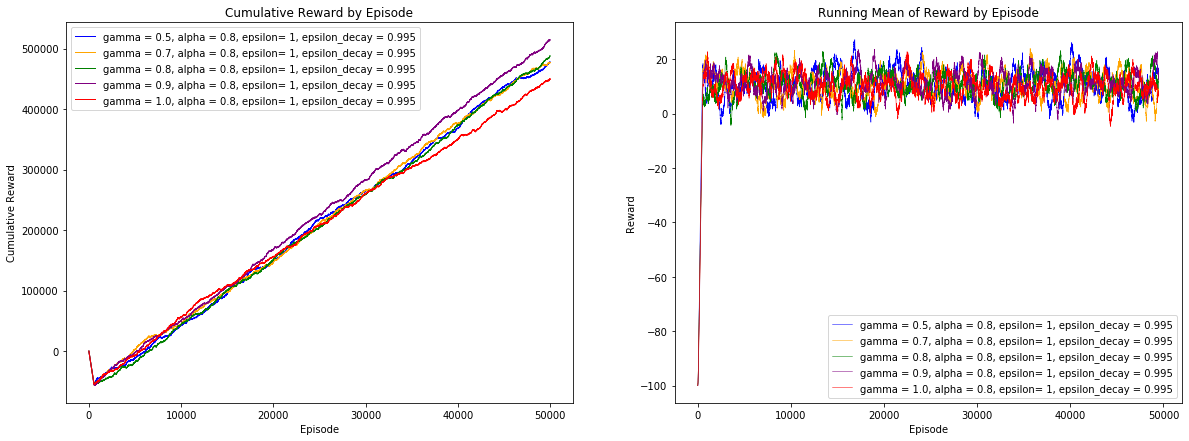

In [15]:
#Plot
plt.figure(figsize=(20,7))
colors={0:'blue', 1:'orange', 2:'green', 3:'purple', 4: 'red'}


# Cumulative rewards
plt.subplot(1,2,1)
for i in range(0,5):
    cum_gamma=np.cumsum(data_gamma['reward'][i])
    plt.plot(cum_gamma, label='gamma = {}, alpha = 0.8, epsilon= 1, epsilon_decay = 0.995'.format(data_gamma['gamma'][i]), linewidth=1, color=colors[i])   
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')



# Running mean rewards
plt.subplot(1,2,2)
for i in range(0,5):
    run_mean_gamma=running_mean(data_gamma['reward'][i], 500) # step size: 500
    plt.plot(run_mean_gamma, label='gamma = {}, alpha = 0.8, epsilon= 1, epsilon_decay = 0.995'.format(data_gamma['gamma'][i]), linewidth=0.5, color=colors[i])
    
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')


### 2. Learning Rate

In [29]:
#--------------------------------------------#
#                 Learning Rate
#--------------------------------------------#

alphas=[0.5, 0.6, 0.7, 0.9, 1] # Learning Rate
state_size = env.nS
action_size = env.nA
result_alpha = []

print('Start ...')
for alpha in alphas:
    print(' alpha :', alpha)
    # Create Q-Learning Agent
    Q_Agent = QLearning(state_size, action_size, 0.9, alpha, 1)       
    # Training Agent
    episodes = 50000  #Number of episodes 
    Q_Rewards = [] # To store the rewards per episode
    for episode in range(0, episodes):
        state = env.reset() # Reset Environment 
        done = False
        while not done:
            # Pick Next Action via egreedy policy
            action = Q_Agent.action_policy_egreedy(state)
            # Advance to next step
            next_state, reward, done, info = env.step(action) 
            # Update Q entries
            Q_Agent.update_Q(state, action, reward, next_state)
            state = next_state
        
        # Update Epsilon 
        if Q_Agent.epsilon >= Q_Agent.epsilon_min : 
            Q_Agent.epsilon *= Q_Agent.epsilon_decay
    
        Q_Rewards.append(reward) 
    result_alpha.append([alpha, Q_Rewards])
print('End ...')

Start ...
 alpha : 0.5
 alpha : 0.6
 alpha : 0.7
 alpha : 0.9
 alpha : 1
End ...


In [30]:
#--------------------------------------------#
#         Performance Evaluation 
#--------------------------------------------#

data_alpha = pd.DataFrame(result_alpha, columns = ['alpha', 'reward'])  

#Get rewards of last 1000 episodes to shows the reward value achieved consistently towards the end of the process

#To store last 1000 episodes rewards
last_1k_rwrd_alpha=pd.DataFrame()

for i in range(0,5):
    last_1k_rwrd_alpha[i]=data_alpha['reward'][i][-1000:]
   
    
#Find mean of the last 1000 episodes rewards and store 
data_alpha['mean_rwrd_lst_1k']=last_1k_rwrd_alpha.mean()       
data_alpha

,alpha,reward,mean_rwrd_lst_1k
0,0.5,"[-100, -100, -100, -100, -100, -100, -100, -10...",10.2
1,0.6,"[-100, -100, -100, -100, -100, -100, -100, -10...",11.6
2,0.7,"[-100, -100, -100, -100, -100, -100, -100, -10...",8.0
3,0.9,"[-100, -100, -100, -100, -100, -100, -100, -10...",12.4
4,1.0,"[-100, -100, -100, -100, -100, -100, -100, -10...",9.0


Text(0.5, 1.0, 'Running Mean of Reward by Episode')

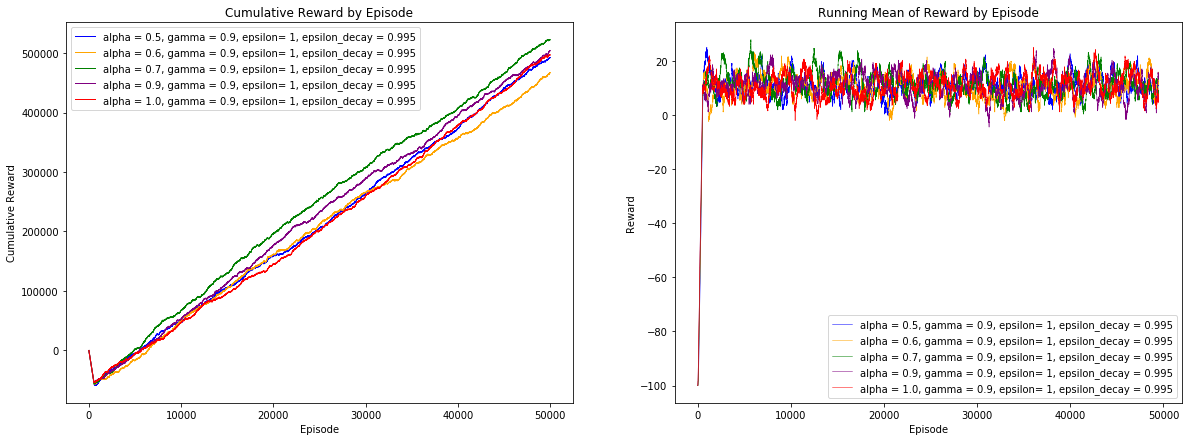

In [31]:
#Plot
plt.figure(figsize=(20,7))
colors={0:'blue', 1:'orange', 2:'green', 3:'purple', 4: 'red'}


# Cumulative rewards
plt.subplot(1,2,1)
for i in range(0,5):
    cum_alpha=np.cumsum(data_alpha['reward'][i])
    plt.plot(cum_alpha, label='alpha = {}, gamma = 0.9, epsilon= 1, epsilon_decay = 0.995'.format(data_alpha['alpha'][i]), linewidth=1, color=colors[i])
    
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')



# Running mean rewards
plt.subplot(1,2,2)
for i in range(0,5):
    run_mean_alpha=running_mean(data_alpha['reward'][i], 500)
    plt.plot(run_mean_alpha, label='alpha = {}, gamma = 0.9, epsilon= 1, epsilon_decay = 0.995'.format(data_alpha['alpha'][i]), linewidth=0.5, color=colors[i])
    
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')



### 3. Decay Rate

In [82]:
#--------------------------------------------#
#                Decay Rate
#--------------------------------------------#


decays=[.995, 0.9995, 0.99955, 0.999955] # Decay Rate
state_size = env.nS
action_size = env.nA
performance_decay = []

print('Start ...')
for decay in decays:
    print(' decay :', decay)
    # Create Q-Learning Agent
    Q_Agent = QLearning(state_size, action_size, 0.9, 0.9, 1)
    Q_Agent.epsilon_decay = decay    
    # Training Agent
    episodes = 50000  #Number of episodes 
    Q_Rewards = [] # To store the rewards per episode

    for episode in range(0, episodes):
        state = env.reset() # Reset Environment 
        done = False
        while not done:
            # Pick Next Action via egreedy policy
            action = Q_Agent.action_policy_egreedy(state)
            # Advance to next step
            next_state, reward, done, info = env.step(action) 
            # Update Q entries
            Q_Agent.update_Q(state, action, reward, next_state)
            state = next_state
        
        # Update Epsilon 
        if Q_Agent.epsilon >= Q_Agent.epsilon_min : 
            Q_Agent.epsilon *= Q_Agent.epsilon_decay
    
        Q_Rewards.append(reward) 
    performance_decay.append([decay, Q_Rewards])
print('End ...')

Start ...
 decay : 0.995
 decay : 0.9995
 decay : 0.99955
 decay : 0.999955
End ...


In [84]:
#--------------------------------------------#
#         Performance Evaluation 
#--------------------------------------------#

data_decay = pd.DataFrame(performance_decay, columns = ['decay', 'reward'])  

#Get rewards of last 1000 episodes to shows the reward value achieved consistently towards the end of the process

#To store last 1000 episodes rewards
last_1k_rwrd_decay=pd.DataFrame()
for i in range(0,4):
    last_1k_rwrd_decay[i]=data_decay['reward'][i][-1000:]
   
    
#Find mean of the last 1000 episodes rewards and store 
data_decay['mean_rwrd_lst_1k']=last_1k_rwrd_decay.mean()        
data_decay

,decay,reward,mean_rwrd_lst_1k
0,0.995000,"[-100, -100, -100, -100, -100, -100, -100, -10...",10.6
1,0.999500,"[-100, -100, -100, -100, -100, -100, -100, -10...",10.4
2,0.999550,"[-100, -100, -100, -100, -100, -100, -100, -10...",8.8
3,0.999955,"[-100, -100, -100, -100, -100, -100, -100, -10...",-39.6


Text(0.5, 1.0, 'Running Mean of Reward by Episode')

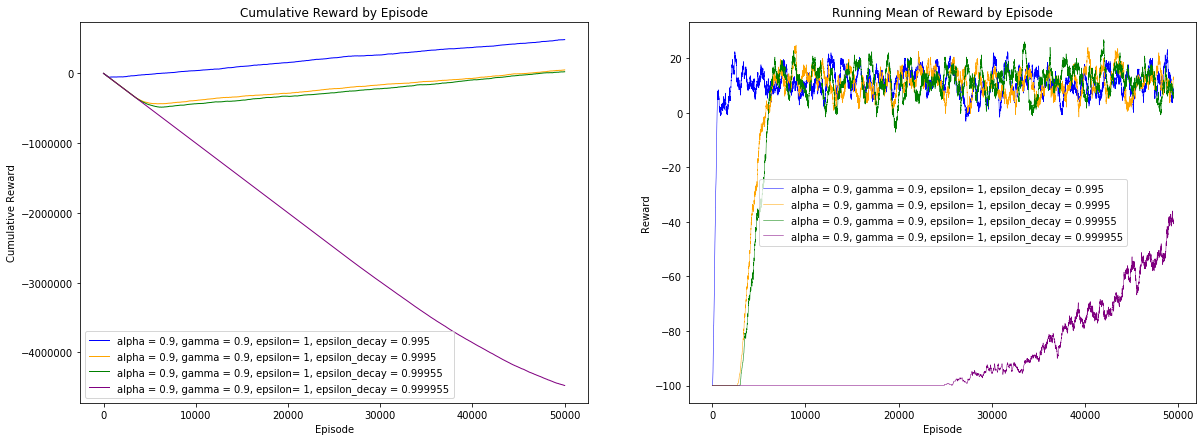

In [128]:
#Plot
plt.figure(figsize=(20,7))
colors={0:'blue', 1:'orange', 2:'green', 3:'purple', 4: 'red'}


# Cumulative rewards
plt.subplot(1,2,1)
for i in range(0,4):
    cum_decay=np.cumsum(data_decay['reward'][i])
    plt.plot(cum_decay, label='alpha = 0.9, gamma = 0.9, epsilon= 1, epsilon_decay = {}'.format(data_decay['decay'][i]), linewidth=1, color=colors[i])
    
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')



# Running mean rewards
plt.subplot(1,2,2)
for i in range(0,4):
    run_mean_decay=running_mean(data_decay['reward'][i], 500)
    plt.plot(run_mean_decay, label='alpha = 0.9, gamma = 0.9, epsilon= 1, epsilon_decay = {}'.format(data_decay['decay'][i]), linewidth=0.5, color=colors[i])
    
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Running Mean of Reward by Episode')


